In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import os

os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [16]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [18]:
def imshow(img):
    img = torchvision.utils.make_grid(img, nrow=10) # 1行に表示する数
    img = img / 2 + 0.5 # 正規化から元に戻す
    npimg = img.detach().numpy() # tensor型からnumpy型に
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (RGB, H, W) から(H, W, RGB)に変換
    plt.show()

In [19]:
def train(net, criterion, optimizer, epochs, trainloader, input_size):
    losses = []
    output_and_label = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch}, ', end='')
        running_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            img = img.to(device)
            img = img.reshape(-1, input_size)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

### DataLoaderを教師データ，試験データいずれもshuffle有りとしているため，実行結果は不定．結論的には，k-meansを含めて上手く実行出来た．
### 追加実験する際は，教師データのshuffle=Falseとするのも一案と思われる．

In [20]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10('./data', train=True, transform=transform, download=True)
testset = CIFAR10('./data', train=False, transform=transform, download=True)

batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size // 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


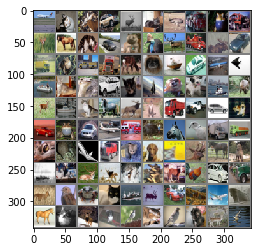

torch.Size([100, 3, 32, 32])


In [21]:
iterator = iter(trainloader)
img, _ = next(iterator)
imshow(img)
print(img.size())

In [22]:
# initで各層を定義しておき，forwardで繋げて利用する．
class AutoEncoder2(torch.nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [23]:
input_size = 3 * 32 * 32

encoder = torch.nn.Sequential(
    torch.nn.Linear(input_size, input_size // 4), # (3072, 768)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size // 12), # (768, 256)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 24) # (256, 128)
)

decoder = torch.nn.Sequential(
    torch.nn.Linear(input_size // 24, input_size // 12), # (128, 256)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 4), # (256, 768)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size), # (768, 3072)
    torch.nn.Tanh()
)

net = AutoEncoder2(encoder, decoder)
net = net.to(device)

In [24]:
criterion = torch.nn.MSELoss() # L2損失に相当
optimizer = torch.optim.SGD(net.parameters(), lr=0.5) # 確率的勾配降下法
EPOCHS = 50

output_and_label, losses = train(
    net, criterion, optimizer, EPOCHS, trainloader, input_size)

epoch: 1, loss: 0.24267819046974182
epoch: 2, loss: 0.16328747406601907
epoch: 3, loss: 0.14528797633945942
epoch: 4, loss: 0.13235574075579642
epoch: 5, loss: 0.12318069140613079
epoch: 6, loss: 0.10841521415114402
epoch: 7, loss: 0.09867582261562348
epoch: 8, loss: 0.09248490792512894
epoch: 9, loss: 0.08903568293154239
epoch: 10, loss: 0.08762936693429947
epoch: 11, loss: 0.08520977760851384
epoch: 12, loss: 0.08254983472824097
epoch: 13, loss: 0.08047472769021988
epoch: 14, loss: 0.07830622167885304
epoch: 15, loss: 0.07618681012094021
epoch: 16, loss: 0.07451611669361591
epoch: 17, loss: 0.07303958632051945
epoch: 18, loss: 0.07148209905624389
epoch: 19, loss: 0.06985391688346863
epoch: 20, loss: 0.06828950464725494
epoch: 21, loss: 0.06709806359559298
epoch: 22, loss: 0.06605336780846119
epoch: 23, loss: 0.06516878195106983
epoch: 24, loss: 0.06439797342568636
epoch: 25, loss: 0.06355568850040436
epoch: 26, loss: 0.06278768426179886
epoch: 27, loss: 0.06206401386857033
epoch: 28,

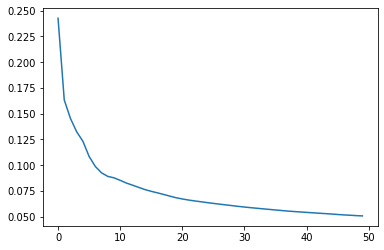

In [25]:
plt.plot(losses)

torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])


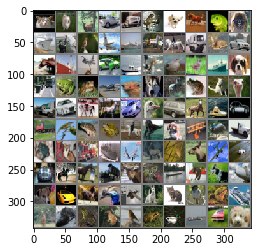

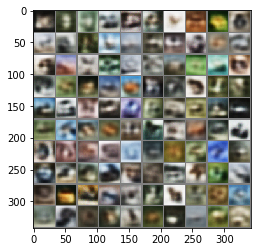

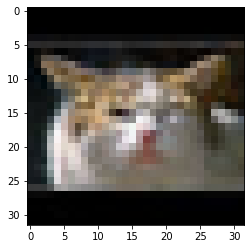

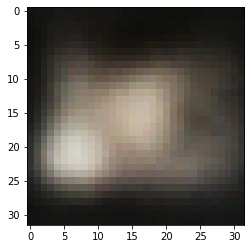

In [26]:
img, org = output_and_label[-1]
img = img.cpu().reshape(-1, 3, 32, 32)
org = org.cpu().reshape(-1, 3, 32, 32)
print(org.shape)
print(img.shape)
imshow(org)
imshow(img)

# orgが元画像，imgが推定した後の画像
imshow(org[0])
imshow(img[0])

### 学習したラベルは使わずにモデルを保存

In [27]:
torch.save(net, '128epch50.pth')
torch.save(output_and_label, 'output_and_label50.pth')
torch.save(net.state_dict(), 'weight_and_bias50.pth')

In [28]:
model_wb = torch.load("./weight_and_bias50.pth")
print(model_wb)
print()

OrderedDict([('enc.0.weight', tensor([[ 0.0051, -0.0021,  0.0144,  ...,  0.0142, -0.0146, -0.0058],
        [ 0.0125, -0.0185, -0.0040,  ..., -0.0056, -0.0076,  0.0074],
        [ 0.0197,  0.0041, -0.0119,  ..., -0.0028,  0.0164,  0.0072],
        ...,
        [-0.0108, -0.0088,  0.0106,  ..., -0.0109, -0.0166, -0.0185],
        [ 0.0043,  0.0126,  0.0120,  ..., -0.0034, -0.0053,  0.0142],
        [ 0.0025, -0.0047, -0.0072,  ...,  0.0097,  0.0036, -0.0043]],
       device='cuda:0')), ('enc.0.bias', tensor([-6.2939e-02, -3.5393e-02, -3.5078e-02, -6.5616e-02, -3.5347e-03,
        -1.6405e-02, -1.8178e-02,  2.6394e-03,  2.1912e-02, -3.5554e-02,
         4.5824e-04, -5.0880e-02,  1.1968e-02, -5.9605e-03, -4.4474e-02,
         3.7906e-02,  9.4043e-03, -5.3763e-02, -8.3893e-02, -5.8824e-02,
        -2.6041e-02, -1.2607e-02, -4.3791e-03,  2.9660e-02, -5.0606e-02,
         1.9431e-02, -6.1163e-02, -6.6910e-02, -9.6937e-02, -2.1977e-02,
        -6.2499e-03,  1.8070e-02,  1.6872e-02, -3.0393e-0

### エンコーダ部分のみ再定義

In [29]:
class AutoEncoder3(torch.nn.Module):
    def __init__(self, enc):
        super().__init__()
        self.enc = enc
        #self.dec = dec
    def forward(self, x):
        y = self.enc(x)
        #x = self.dec(x)
        return y

input_size = 3 * 32 * 32

encoder3 = torch.nn.Sequential(
    torch.nn.Linear(input_size, input_size // 4), # (3072, 768)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size // 12), # (768, 256)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 24) # (256, 128)
)

### モデルを評価モードに変更して，テスト用の画像を読み込んで，モデルに渡せる形式にする

In [30]:
model = AutoEncoder3(encoder3)
model = model.to(device)

model.load_state_dict(model_wb, strict=False)
model.eval()

AutoEncoder3(
  (enc): Sequential(
    (0): Linear(in_features=3072, out_features=768, bias=True)
    (1): ReLU()
    (2): Linear(in_features=768, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [31]:
# 学習用データセット：縦横32ピクセルのRGBの画像が50000枚
print(trainset.data.shape)


# テスト用データセット：縦横32ピクセルのRGBの画像が10000枚
print(testset.data.shape)


# クラス一覧を確認し，一応保持
classes = trainset.classes
print(classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 32, 32])


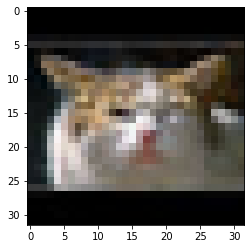

In [32]:
print(org[0].shape)
imshow(org[0])

In [33]:
# CIFAR-10のランダム100枚を学習済みのモデルに入力する
org = org.to(device)
# outputs = model(img)
print(org.shape)

torch.Size([100, 3, 32, 32])


In [34]:
output = model(org[0].flatten()) # 次元合わせのためにflatten()が必要
print(output)

tensor([ 0.5760,  0.4723, -3.4412,  2.5009,  0.7759,  0.9507, -3.5416, -3.6999,
         0.5653,  3.7874,  2.5336, -2.5603, -0.5360, -0.8230, -2.0370, -0.5658,
         0.6603,  5.0183, -1.0281,  1.4849, -1.6086, -1.6702,  1.8809,  0.1623,
         0.8298,  2.7731,  0.6112, -1.7448,  0.0253,  2.1910, -2.9384, -2.7434,
        -0.2400, -2.0707,  1.8750, -1.3519,  3.2513,  0.3621, -4.1410,  0.4757,
         2.9181,  3.3332,  3.8108,  5.7529, -0.8087, -1.1718,  1.0722,  1.3900,
        -3.3391,  0.0489, -1.4341, -3.3533,  0.0782,  4.3270,  4.1029, -0.4780,
         0.6473,  0.7728,  2.6395, -4.5945, -0.4339,  0.8674,  0.5362, -1.1633,
         1.5984, -2.4102,  1.9206, -4.5984,  4.0942,  2.1131,  1.2682,  4.0302,
        -4.2573,  1.5725, -2.2431, -2.0174, -0.0521, -3.3254, -0.4174, -0.7963,
        -0.0928, -1.5029, -0.7536,  1.0725, -3.8470, -2.5382,  0.2849, -2.1772,
         2.3405, -2.7365, -0.0471, -1.7028,  0.5904, -0.0342,  1.1996,  4.2309,
         6.1939,  1.8738,  1.1334,  4.05

In [35]:
features = []
for i in range(100):
    if i==0:
        features = model(org[i].flatten())
    else:
        temp = model(org[i].flatten())
        features = torch.vstack([features, temp])

print(features.shape)
print(features[1])

torch.Size([100, 128])
tensor([ 1.9907e+00, -2.5226e-01, -2.8292e+00,  2.2867e+00,  2.2642e+00,
         1.3366e-01, -1.8820e+00, -2.3664e+00, -5.0095e-01,  9.0007e-01,
         1.5783e+00, -3.8638e-01, -7.5249e-01, -1.1674e+00, -7.0411e-01,
         5.3498e-01, -9.1180e-02,  3.1871e+00, -1.3095e+00, -6.9232e-01,
        -2.1820e+00,  1.5993e-01,  2.5093e+00, -1.3308e+00,  1.7423e+00,
         2.0514e+00,  1.5344e+00, -9.7550e-01,  4.0180e-01,  9.3337e-02,
        -1.4232e+00, -1.9269e+00,  4.4568e-01, -1.3113e+00,  2.7327e-01,
        -1.2783e+00,  1.2440e+00,  9.7481e-01, -2.4767e+00,  2.6992e-01,
         2.6198e+00,  2.0012e+00,  3.0308e+00,  4.2419e+00, -4.6349e-02,
        -4.9751e-01,  1.6805e+00,  1.7163e+00, -1.9691e+00,  3.6757e-01,
        -1.1303e+00, -1.2265e+00, -5.6481e-01,  1.4834e+00,  6.2510e-01,
         2.5218e-01,  5.8409e-02,  9.6381e-02,  1.7789e+00, -4.6496e+00,
        -7.6491e-01,  8.2437e-01,  1.5392e+00, -1.6173e+00,  2.5256e+00,
        -2.0796e+00,  2.9917

###  k=5 でk-meansでクラスタリング

In [36]:
feat = features.cpu().detach().numpy()
print(feat)

[[ 0.5760023   0.47228774 -3.441218   ...  3.564519    0.48204413
   1.925807  ]
 [ 1.9907159  -0.2522619  -2.8292315  ...  2.6584504   1.2482021
   1.5081553 ]
 [ 1.678622   -0.14016561 -0.6976462  ...  2.2797925  -0.30723798
   1.8786803 ]
 ...
 [ 1.4556949  -0.158699   -0.6259795  ...  0.8488201   0.11995599
   0.4780991 ]
 [ 1.4422344  -0.14356059 -2.617207   ...  2.0200474  -0.7656371
   0.23752768]
 [ 1.3208503  -1.0012991  -2.2589982  ...  1.8803787  -0.4524273
   2.1960258 ]]


In [37]:
from sklearn.cluster import KMeans
groups = KMeans(n_clusters=5, random_state=0).fit_predict(feat)
print(groups)

[3 0 1 2 0 1 4 0 3 1 2 2 0 2 2 0 1 2 1 1 2 2 2 0 2 1 1 1 2 1 0 1 3 1 1 0 0
 4 0 0 0 2 2 0 2 1 1 1 0 3 1 2 1 1 1 0 2 1 0 2 1 1 1 2 2 0 0 1 2 0 0 1 0 0
 1 0 1 2 0 2 0 3 1 1 1 0 4 1 0 1 1 0 0 0 2 0 3 1 0 2]


In [38]:
print(groups[0])

3


In [39]:
def imshow5(img):
    img = torchvision.utils.make_grid(img, nrow=5) # 1行に表示する数
    img = img / 2 + 0.5 # 正規化から元に戻す
    #npimg = img.detach().numpy() # tensor型からnumpy型に
    npimg = img
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (RGB, H, W) から(H, W, RGB)に変換
    plt.show()


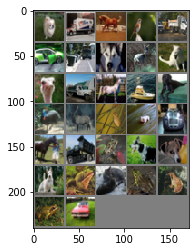

クラス 0 の個数： 32


In [40]:
classNum = 0

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

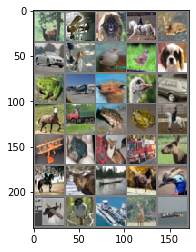

クラス 1 の個数： 35


In [41]:
classNum = 1

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

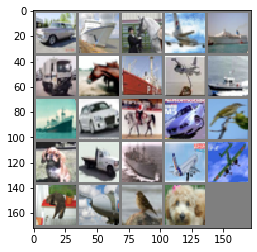

クラス 2 の個数： 24


In [42]:
classNum = 2

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

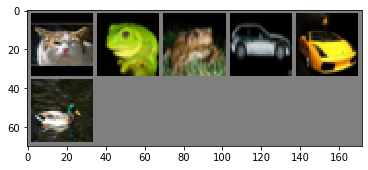

クラス 3 の個数： 6


In [43]:
classNum = 3

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

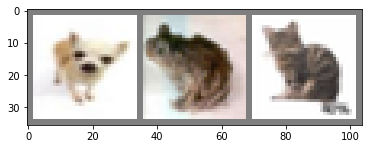

クラス 4 の個数： 3


In [44]:
classNum = 4

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

### k=10 のk-meansでクラスタリング

In [45]:
from sklearn.cluster import KMeans
groups = KMeans(n_clusters=10, random_state=0).fit_predict(feat)
print(groups)

[5 3 6 8 1 0 9 1 5 0 8 6 3 2 6 3 0 8 6 6 8 6 4 0 2 6 6 0 2 1 1 0 5 6 6 3 3
 9 3 3 3 8 4 3 4 0 6 0 3 5 0 8 1 0 6 7 4 0 1 2 4 6 6 8 2 1 3 0 4 3 3 4 1 7
 0 3 1 4 3 8 1 5 0 6 6 3 9 6 3 6 6 7 3 3 4 3 5 6 3 6]


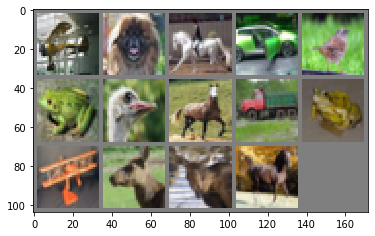

クラス 0 の個数： 14


In [46]:
classNum = 0

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

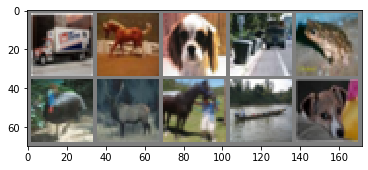

クラス 1 の個数： 10


In [47]:
classNum = 1

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

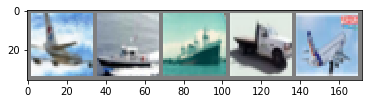

クラス 2 の個数： 5


In [51]:
classNum = 2

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

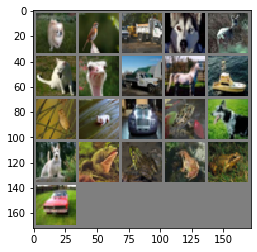

クラス 3 の個数： 21


In [52]:
classNum = 3

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

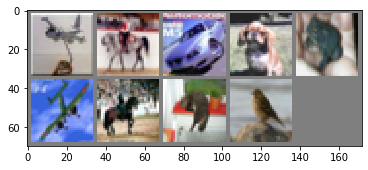

クラス 4 の個数： 9


In [53]:
classNum = 4

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

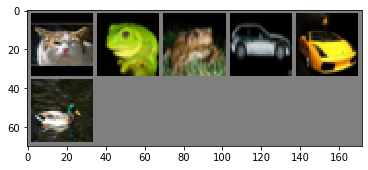

クラス 5 の個数： 6


In [54]:
classNum = 5

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

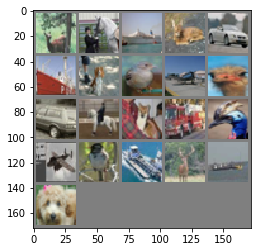

クラス 6 の個数： 21


In [55]:
classNum = 6

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

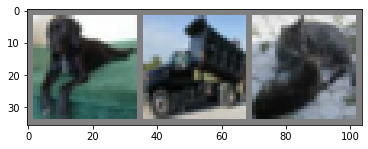

クラス 7 の個数： 3


In [48]:
classNum = 7

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

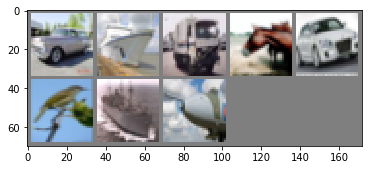

クラス 8 の個数： 8


In [49]:
classNum = 8

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

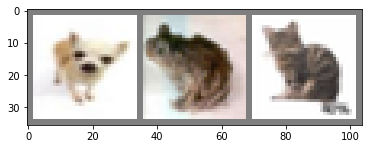

クラス 9 の個数： 3


In [50]:
classNum = 9

idx = np.where(groups==classNum) # クラス数と一致するインデックスを，groupsの中から抽出．
imshow5(org[idx].cpu())

idx = np.array(idx).flatten() # クラスの個数を計算するためにnumpyに変換して，flatten
print("クラス", classNum, "の個数：", len(idx))

### 検討
- kmeans法は与える乱数により結果が変動していた．kmeansの乱数シードは0と設定．
- いずれの乱数の設定値においてもそれなりにクラスタリング出来ているように見えた．

### 問．似ている画像がグループになるでしょうか？
- k-meansの結果から，RGB情報の似ている画像が，グループになることが分かった．